<a href="https://colab.research.google.com/github/Lamyae19/Rose-Image-Classification-with-ANN/blob/main/Rose_Image_Classification_with_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rose Image Classification with ANN

## Step 1: Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import cv2
from skimage import feature, exposure
from skimage.feature import hog

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Step 2: Load and Preprocess Dataset

In [ ]:
base_dir = 'dataset'

In [ ]:
def extract_features_from_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    img = cv2.resize(img, (128, 128))

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    hog_features = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), visualize=False)

    # Extract color histograms
    hist_r = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()
    hist_h = cv2.calcHist([hsv], [0], None, [32], [0, 180]).flatten()
    hist_s = cv2.calcHist([hsv], [1], None, [32], [0, 256]).flatten()

    means = np.mean(img, axis=(0, 1))
    stds = np.std(img, axis=(0, 1))
    skewness = np.mean(((img - means) / (stds + 1e-10))**3, axis=(0, 1))
    kurtosis = np.mean(((img - means) / (stds + 1e-10))**4, axis=(0, 1))

    combined_features = np.concatenate([
        hog_features,
        hist_r,
        hist_g,
        hist_b,
        hist_h,
        hist_s,
        means, stds, skewness, kurtosis
    ])

    return combined_features

def load_and_extract_features(base_dir):
    features = []
    labels = []
    class_names = sorted(os.listdir(base_dir))
    class_mapping = {name: i for i, name in enumerate(class_names)}

    print(f"Found classes: {class_names}")

    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        print(f"Processing class: {class_name}")
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            if not os.path.isfile(image_path):
                continue

            img_features = extract_features_from_image(image_path)
            if img_features is not None:
                features.append(img_features)
                labels.append(class_mapping[class_name])

    return np.array(features), np.array(labels)

In [ ]:
features, labels = load_and_extract_features(base_dir)


print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split and scaled:")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")

Found classes: ['not_rose', 'rose']
Processing class: not_rose
Processing class: rose
Features shape: (1257, 8272)
Labels shape: (1257,)
Data split and scaled:
X_train shape: (1005, 8272)
X_test shape: (252, 8272)


## Step 3: Build and Compile the ANN Model

In [ ]:
def create_ann_model(input_dim):

    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),

        Dense(256, activation='relu'),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')  # Binary classification: rose or not_rose
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
input_dim = X_train_scaled.shape[1]
model = create_ann_model(input_dim)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │     4,235,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,408,321 (16.82 MB)

 Trainable params: 4,408,321 (16.82 MB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Train the Model

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('rose_classifier_ann.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.7873 - loss: 0.5747 - val_accuracy: 0.7264 - val_loss: 0.6515 - learning_rate: 2.0000e-04
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8313 - loss: 0.4091 - val_accuracy: 0.7114 - val_loss: 0.6825 - learning_rate: 2.0000e-04
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8470 - loss: 0.3263 - val_accuracy: 0.7015 - val_loss: 0.7347 - learning_rate: 2.0000e-04
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9110 - loss: 0.2612 - val_accuracy: 0.6816 - val_loss: 0.8136 - learning_rate: 2.0000e-04
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9344 - loss: 0.1723 - val_accuracy: 0.6816 - val_loss: 0.8995 - learning_rate: 2.0000e-04
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9595 - loss: 0.1199 - val_accuracy: 0.6766 - val_loss: 0.9339 - learning_rate: 2.0000e-04
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.966

## Step 5: Evaluate the Model

In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7073 - loss: 0.5636
Test accuracy: 0.7222


## Step 6: Confusion Matrix & Report

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Classification Report:
              precision    recall  f1-score   support

        rose       0.63      0.62      0.63        95
    not_rose       0.77      0.78      0.78       157

    accuracy                           0.72       252
   macro avg       0.70      0.70      0.70       252
weighted avg       0.72      0.72      0.72       252



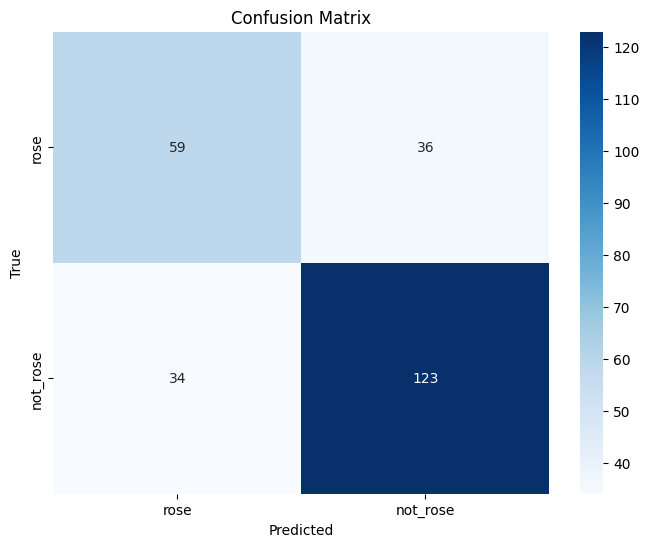

In [ ]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['rose', 'not_rose']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['rose', 'not_rose'],
            yticklabels=['rose', 'not_rose'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Step 7: Plot Accuracy and Loss

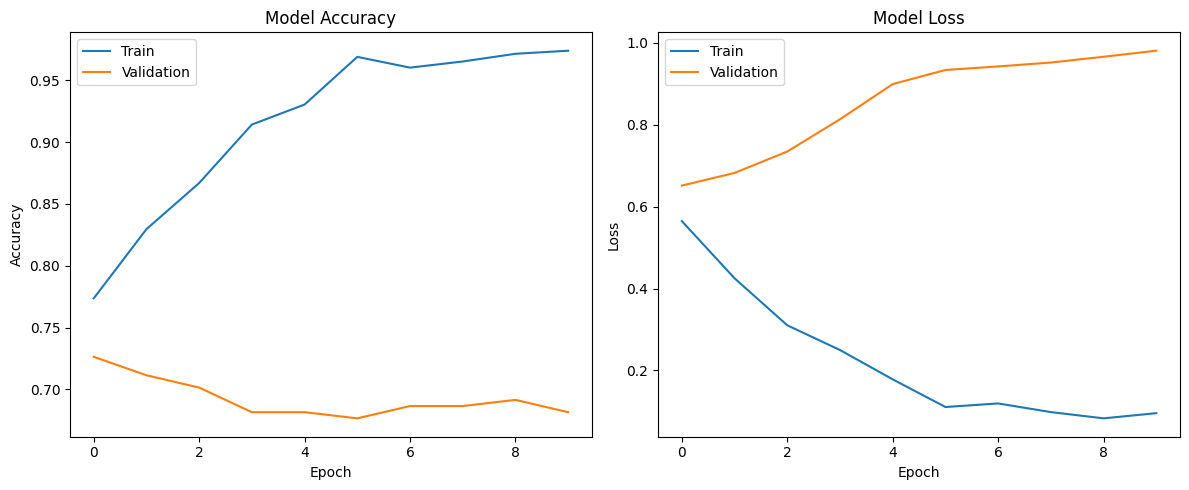

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Step 8: Save the model and the scaler

In [ ]:
import joblib
joblib.dump(scaler, 'feature_scaler.pkl')

model.save('rose_classifier_ann.keras')

## Step 9: Test the Model with New Data

In [ ]:
def predict_image(path_or_url, is_url=False, model_path='rose_classifier_ann.keras', scaler_path='feature_scaler.pkl'):
  import requests

  model = tf.keras.models.load_model(model_path)
  scaler = joblib.load(scaler_path)

  if is_url:
      try:
          response = requests.get(path_or_url, timeout=10)
          response.raise_for_status()
          img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
          img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
          if img is None:
              raise ValueError("Could not decode image from URL")
      except Exception as e:
          print(f"Error loading image from URL: {str(e)}")
          return None, None
  else:
      img = cv2.imread(path_or_url)
      if img is None:
          print(f"Could not load image from path: {path_or_url}")
          return None, None

  img = cv2.resize(img, (128, 128))

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=False)

  hist_r = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
  hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
  hist_b = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()
  hist_h = cv2.calcHist([hsv], [0], None, [32], [0, 180]).flatten()
  hist_s = cv2.calcHist([hsv], [1], None, [32], [0, 256]).flatten()

  means = np.mean(img, axis=(0, 1))
  stds = np.std(img, axis=(0, 1))
  skewness = np.mean(((img - means) / (stds + 1e-10))**3, axis=(0, 1))
  kurtosis = np.mean(((img - means) / (stds + 1e-10))**4, axis=(0, 1))

  combined_features = np.concatenate([
      hog_features,
      hist_r / (np.sum(hist_r) + 1e-10),
      hist_g / (np.sum(hist_g) + 1e-10),
      hist_b / (np.sum(hist_b) + 1e-10),
      hist_h / (np.sum(hist_h) + 1e-10),
      hist_s / (np.sum(hist_s) + 1e-10),
      means, stds, skewness, kurtosis
  ])

  scaled_features = scaler.transform(combined_features.reshape(1, -1))

  pred_prob = model.predict(scaled_features, verbose=0)[0][0]
  predicted_class = 'rose' if pred_prob >= 0.5 else 'not rose'
  confidence = pred_prob if predicted_class == 'rose' else 1 - pred_prob

  plt.figure(figsize=(4, 3))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(f'Prediction: {predicted_class} (Confidence: {confidence:.2f})')
  plt.axis('off')
  plt.show()

  return predicted_class, confidence

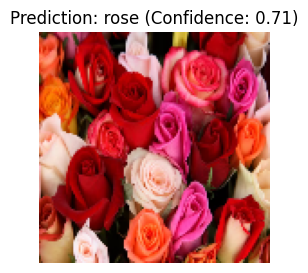

In [ ]:
test_img_path = os.path.join('/content/Screenshot 2025-05-20 083544.png')
predicted_class, confidence = predict_image(test_img_path)

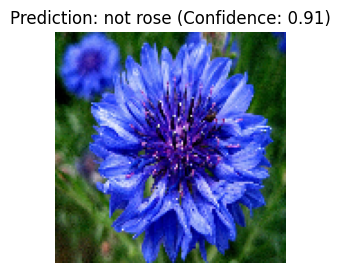

In [ ]:
test_img_url='https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Bachelor%27s_button%2C_Basket_flower%2C_Boutonniere_flower%2C_Cornflower_-_3.jpg/1200px-Bachelor%27s_button%2C_Basket_flower%2C_Boutonniere_flower%2C_Cornflower_-_3.jpg'
predicted_class, confidence = predict_image( test_img_url, True)